# <font color='darkblue'> Recommendations with IBM Watson. Part I</font>
## <font color='darkblue'>Data Preprocessing and Data Analysis</font>

Several recommendation methods are investigated on real data from the IBM Watson Studio platform. 

## <font color='darkblue'>Environment SetUp</font>

In [1]:
# General libraries and packages

import pandas as pd
import numpy as np
import pickle

# Recommendation systems library
import surprise

# Packages and libraries for content based recs
import re

# NLP packages
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Data processing packages
from sklearn.feature_extraction.text import TfidfVectorizer

# Import linear kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

In [3]:
# Use 2 decimal places in output display
pd.set_option("display.precision", 2)

# Don't wrap dataframe across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set the maximum widths of columns
pd.set_option("display.max_colwidth", 90)

# Set max rows displayed in output to 20
pd.set_option("display.max_rows", 20)

## <font color='darkblue'>Get the Data</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>Data provided by Udacity under Data Scientist Nanodegree.</li>
        <li>There are two csv files: user-item interactions, articles with titles and body text.</li>
    </ul>

</div>

In [4]:
# Read in the user-item interaction file
df = pd.read_csv('data/user-item-interactions.csv', index_col=[0])

# Read the articles information file
df_content = pd.read_csv('data/articles_community.csv', index_col=[0])

In [5]:
# Show df to get an idea of the user-item data
df.head(2)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b


In [6]:
# Check the size of the user_item data
df.shape

(45993, 3)

In [7]:
# Show df_content to get an idea of the content data
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
3,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
5,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",Communicating data science: A guide to presenting your work,Live,1


In [8]:
# Check the size of the articles content data
df_content.shape

(1056, 5)

## <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In this part we get some insight into the two datasets.

### <font color='darkblue'>Parse the email column</font>

In [9]:
# Display the null values counts
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

The `email_mapper` function maps users to ids. The small number of null values are not discarded, they are instead attributed to a single user.

In [10]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    
    '''
    Function that maps the user email to a generated user_id.
    The initial email column is removed.
    '''
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

In [11]:
# Create a new column called user_id
df['user_id'] = email_mapper()
# Drop the email column
df.drop(columns=['email'], inplace=True)
# Check the outcome
df.head(2)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2


###  <font color='darkblue'>What is the distribution of how many articles a user interacts with in the dataset?</font>

In [12]:
# The number of unique emails - corresponds to the number of unique users
print(f'The number of unique users is {df.user_id.nunique()}.')

The number of unique users is 5149.


In [13]:
# The number of unique articles
print(f'The number of unique articles in the item_user dataset is {df_content.article_id.nunique()}.')

The number of unique articles in the item_user dataset is 1051.


In [14]:
# Create a dataframe to keep track of the articles accessed by a user
articles_per_user = pd.pivot_table(df,
                    values=['article_id'],
                    index='user_id',
                    aggfunc={'article_id': list})
articles_per_user.reset_index(inplace=True)

# Check the outcome
articles_per_user.head(2)

,user_id,article_id
0,1,"[1430.0, 1430.0, 732.0, 1429.0, 43.0, 109.0, 1232.0, 310.0, 1293.0, 1406.0, 1406.0, 32..."
1,2,"[1314.0, 1305.0, 1024.0, 1176.0, 1422.0, 1427.0]"


In [15]:
# Rename column article_id
articles_per_user.rename(columns={'article_id': 'viewed_articles'}, inplace=True)

In [16]:
# Create a new column that records how many articles a user accessed
articles_per_user['articles_count'] = [len(x) for x in articles_per_user.viewed_articles]

# Create a column that records how many unique articles the user accessed
articles_per_user['unique_articles_count'] = [len(set(x)) for x in articles_per_user.viewed_articles]

# Check the outcome
articles_per_user.sort_values(by='articles_count', ascending=False).head(2)

,user_id,viewed_articles,articles_count,unique_articles_count
22,23,"[362.0, 409.0, 409.0, 302.0, 409.0, 14.0, 29.0, 1293.0, 1429.0, 1293.0, 720.0, 1304.0,...",364,135
3781,3782,"[943.0, 658.0, 109.0, 43.0, 1170.0, 1172.0, 1314.0, 43.0, 1338.0, 1160.0, 1276.0, 33.0...",363,135


In [17]:
# 5 Numbers statistics for the article counts per user
articles_per_user.describe()

,user_id,articles_count,unique_articles_count
count,5149.00,5149.00,5149.00
mean,2575.00,8.93,6.54
std,1486.53,16.80,9.99
min,1.00,1.00,1.00
25%,1288.00,1.00,1.00
50%,2575.00,3.00,3.00
75%,3862.00,9.00,7.00
max,5149.00,364.00,135.00


In [18]:
# The median and maximum number of user_article interactions

median_val = df.groupby('user_id').count()['article_id'].median()
print(f'50% of individuals interact with {int(median_val)} articles or fewer.')
max_views_by_user = df.groupby('user_id').count()['article_id'].max()
print(f'The maximum number of user-article interactions by any user is {max_views_by_user}.')

50% of individuals interact with 3 articles or fewer.
The maximum number of user-article interactions by any user is 364.


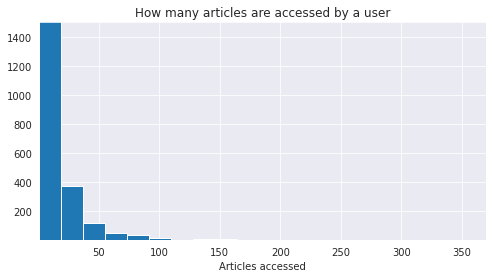

In [19]:
# The histogram of the data in articles_per_user
plt.figure(figsize=(8,4))
plt.hist(articles_per_user.articles_count, bins=20)

# Add labels and title
plt.xlabel('Articles accessed')
plt.title('How many articles are accessed by a user')
plt.xlim(1, 370)
plt.ylim(1, 1500)
plt.grid(True)
plt.show()

In [20]:
# How many users accessed one article only
one_article_users = articles_per_user[articles_per_user['articles_count'] == 1]
print(f'The number of users who accessed one article only is {one_article_users.shape[0]}.')

The number of users who accessed one article only is 1416.


In [21]:
# Identify the right tail outliers using: mean + 2*std  
upper_outliers_article_count = int(articles_per_user.articles_count.mean() + 2 * articles_per_user.articles_count.std())
upper_outliers_users = articles_per_user[articles_per_user.articles_count >= upper_outliers_article_count]
print(f'There are {upper_outliers_users.shape[0]} users who accessed at least {upper_outliers_article_count} articles each.')

There are 190 users who accessed at least 42 articles each.


In [22]:
# Look at the 5 number statistics for the right tail outliers
upper_outliers_users.describe()

,user_id,articles_count,unique_articles_count
count,190.00,190.00,190.00
mean,2152.31,73.23,44.79
std,1885.67,41.72,18.60
min,1.00,42.00,18.00
25%,276.75,50.00,33.00
50%,1207.00,59.50,40.00
75%,3866.50,82.00,52.00
max,5140.00,364.00,135.00


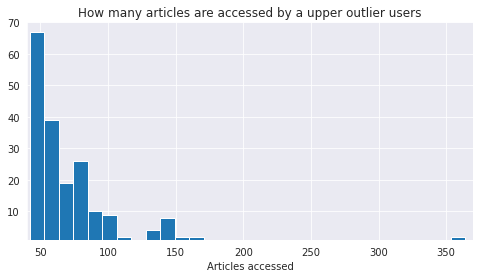

In [23]:
# The histogram of the right tail outlier users data
plt.figure(figsize=(8,4))
plt.hist(upper_outliers_users.articles_count, bins=30)

# Add labels and title
plt.xlabel('Articles accessed')
plt.title('How many articles are accessed by a upper outlier users')
plt.xlim(40, 370)
plt.ylim(1, 70)
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>There are a couple of right tail extreme outliers which we will remove before modeling.</li>
    </ul>

</div>

In [24]:
print(f'There are {upper_outliers_users[upper_outliers_users.articles_count > 200].shape[0]}' +  \
' users who accessed more than 200 articles each.')

There are 2 users who accessed more than 200 articles each.


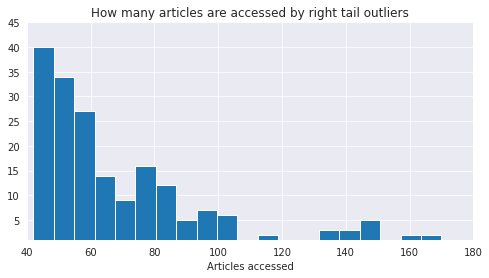

In [25]:
# The histogram of the upper outlier users after removal of the two extreme outliers
plt.figure(figsize=(8,4))
data = upper_outliers_users[upper_outliers_users.articles_count < 200]
plt.hist(data.articles_count, bins=20)

# Add labels and title
plt.xlabel('Articles accessed')
plt.title('How many articles are accessed by right tail outliers')
plt.xlim(40, 180)
plt.ylim(1, 45)
plt.grid(True)
plt.show()

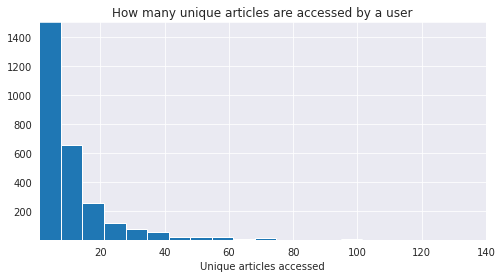

In [26]:
# The histogram of the counts of unique articles accessed by a user
plt.figure(figsize=(8,4))
plt.hist(articles_per_user.unique_articles_count, bins=20)

# Add labels and title
plt.xlabel('Unique articles accessed')
plt.title('How many unique articles are accessed by a user')
plt.xlim(1, 140)
plt.ylim(1, 1500)
plt.grid(True)
plt.show()

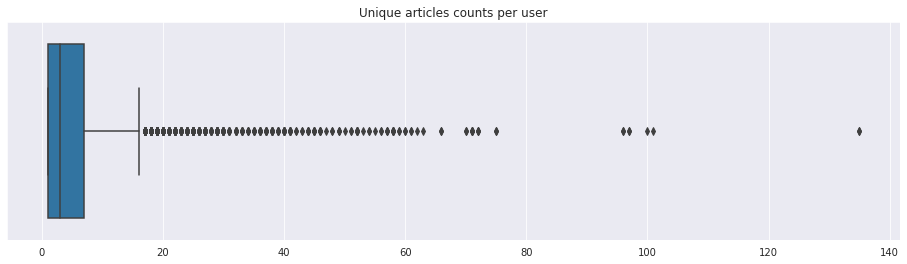

In [27]:
# Boxplot for the unique articles count accessed by each user
plt.figure(figsize=(16,4))

ax = sns.boxplot(x=articles_per_user['unique_articles_count'])

plt.title('Unique articles counts per user')
plt.xlabel('')
plt.show()

In [28]:
# Unique articles accessed counts - extreme right tail outliers
articles_per_user[articles_per_user.unique_articles_count > 80].sort_values(
    by='unique_articles_count', ascending=False)

,user_id,viewed_articles,articles_count,unique_articles_count
22,23,"[362.0, 409.0, 409.0, 302.0, 409.0, 14.0, 29.0, 1293.0, 1429.0, 1293.0, 720.0, 1304.0,...",364,135
3781,3782,"[943.0, 658.0, 109.0, 43.0, 1170.0, 1172.0, 1314.0, 43.0, 1338.0, 1160.0, 1276.0, 33.0...",363,135
48,49,"[1423.0, 173.0, 1423.0, 468.0, 53.0, 1396.0, 1364.0, 379.0, 313.0, 1163.0, 1422.0, 139...",147,101
3696,3697,"[723.0, 606.0, 1174.0, 1305.0, 1160.0, 585.0, 1185.0, 1176.0, 152.0, 1163.0, 1274.0, 1...",145,100
97,98,"[173.0, 1165.0, 1427.0, 651.0, 1274.0, 1165.0, 1274.0, 1425.0, 202.0, 1293.0, 1429.0, ...",170,97
3763,3764,"[1293.0, 409.0, 20.0, 1165.0, 1430.0, 1175.0, 939.0, 1425.0, 1368.0, 1274.0, 1175.0, 1...",169,97
202,203,"[930.0, 1057.0, 1314.0, 793.0, 1368.0, 1396.0, 1368.0, 1396.0, 793.0, 427.0, 833.0, 13...",160,96
4458,4459,"[1185.0, 1324.0, 1054.0, 1386.0, 1430.0, 1430.0, 933.0, 241.0, 1427.0, 1057.0, 1278.0,...",158,96


<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>There are four users that accessed 100 or more unique articles.</li>
        <li>The users that accessed most unique articles are the same users with the largest numbers of article interactions.
    </ul>

</div>

In [29]:
# Dataframe to record the number of times each user interacts with a given article
article_user = df.value_counts(ascending=False).to_frame('user_art_counts').reset_index()
article_user.head()

,article_id,title,user_id,user_art_counts
0,1170.0,"apache spark lab, part 1: basic concepts",223,42
1,1170.0,"apache spark lab, part 1: basic concepts",3358,41
2,1429.0,use deep learning for image classification,23,35
3,1429.0,use deep learning for image classification,3782,35
4,1429.0,use deep learning for image classification,3353,25


In [30]:
# 5 Values descriptive statistics for how many times an user interacts with one article
article_user.user_art_counts.describe()

count    33682.00
mean         1.37
std          1.17
min          1.00
25%          1.00
50%          1.00
75%          1.00
max         42.00
Name: user_art_counts, dtype: float64

In [31]:
# The number of records where the user had only one or two interaction with an article
few_interacts = article_user[article_user.user_art_counts < 6].shape[0]
print(f'About {round((few_interacts/article_user.shape[0])*100,2)}% of the users have 1 to 5 interactions with a given article.')

About 98.84% of the users have 1 to 5 interactions with a given article.


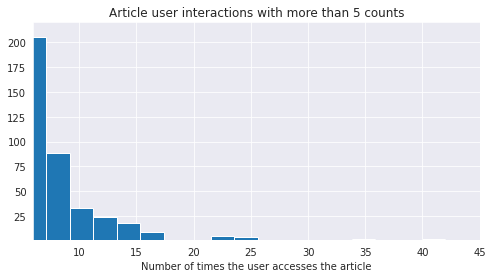

In [32]:
# The histogram of the counts of 4 or more interactions per article
plt.figure(figsize=(8,4))
plt.hist(article_user.user_art_counts, bins=20)

# Add labels and title
plt.xlabel('Number of times the user accesses the article')
plt.title('Article user interactions with more than 5 counts')
plt.xlim(6, 45)
plt.ylim(1, 220)
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>The number of times an article is accessed by the same user has a very right skewed distribution. Most of the users access an article once or twice, almost 99% of the users access the same article at most 5 times.</li>
    </ul>

</div>

###  <font color='darkblue'>Explore and remove duplicate articles from the `df_content` dataframe</font>

In [33]:
# Find and explore duplicate articles
duplicate_articles = df_content[df_content['article_id'].duplicated()]
duplicate_articles.shape

(5, 5)

In [34]:
# Take a look at the duplicates list
duplicate_articles

,doc_body,doc_description,doc_full_name,doc_status,article_id
1103,Follow Sign in / Sign up Home About Insight Data Science Data Engineering Health Data ...,During the seven-week Insight Data Engineering Fellows Program recent grads and experi...,Graph-based machine learning,Live,50
2123,Homepage Follow Sign in / Sign up Homepage * Home\r\n * Data Science Experience\r\n * ...,One of the earliest documented catalogs was compiled at the great library of Alexandri...,How smart catalogs can turn the big data flood into an ocean of opportunity,Live,221
2324,Homepage Follow Sign in Get started Homepage * Home\r\n * Data Science Experience\r\n ...,"Today’s world of data science leverages data from various sources. Commonly, these sou...",Using Apache Spark as a parallel processing framework for accessing REST based data se...,Live,398
3016,This video shows you how to construct queries to access the primary index through the ...,This video shows you how to construct queries to access the primary index through the API,Use the Primary Index,Live,577
3017,Homepage Follow Sign in Get started * Home\r\n * Data Science Experience\r\n * Data Ca...,"If you are like most data scientists, you are probably spending a lot of time to clean...",Self-service data preparation with IBM Data Refinery,Live,232


In [35]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

# Check the outcome
#df_content[df_content['article_id'].duplicated()] 

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>Drop duplicates in the content dataframe.</li>
    </ul>

</div>

###  <font color='darkblue'>Investigation of the unique articles in the item-user dataset</font>

In [36]:
# The total number of unique articles in the dataset
total_articles = df_content.article_id.nunique()
print(f'The number of unique articles on the IBM platform is {total_articles}.')

# The number of unique articles that have at least one user interaction (user-item dataset)
unique_articles = df.article_id.nunique()
print(f'The number of unique articles that have at least one interaction is {unique_articles}.')

The number of unique articles on the IBM platform is 1051.
The number of unique articles that have at least one interaction is 714.


In [37]:
# The number of rows that have no user email in the df dataframe
no_interact_articles = df[df.isna().any(axis=1)]['article_id'].nunique()
print(f'The number of unique articles that have no user interaction in item-user data is {no_interact_articles}.')

The number of unique articles that have no user interaction in item-user data is 0.


In [38]:
# The number of unique users in the dataset (exclude nulls)
unique_users = df.user_id.nunique(dropna=True)
print(f'The number of unique users is {unique_users - 1} since we attributed missing values to a designated user.')

# The number of user-article interactions in the dataset
user_article_interactions = df[['user_id', 'article_id']].shape[0]
print(f'The number of user-article interactions is {user_article_interactions}.')

The number of unique users is 5148 since we attributed missing values to a designated user.
The number of user-article interactions is 45993.


###  <font color='darkblue'>Find the most popular articles</font>

In [39]:
# Count how many times each article is viewed
article_views = pd.DataFrame(df.groupby(['article_id']).count()['user_id'])

# Rename columns
article_views.rename(columns={'user_id': 'views'}, inplace=True)

# Check the outcome
article_views.head(2)

,views
article_id,
0.0,14
2.0,58


In [40]:
# Look at the 5 number statistics for article views
article_views.describe()

,views
count,714.00
mean,64.42
std,109.18
min,1.00
25%,8.00
50%,25.00
75%,69.00
max,937.00


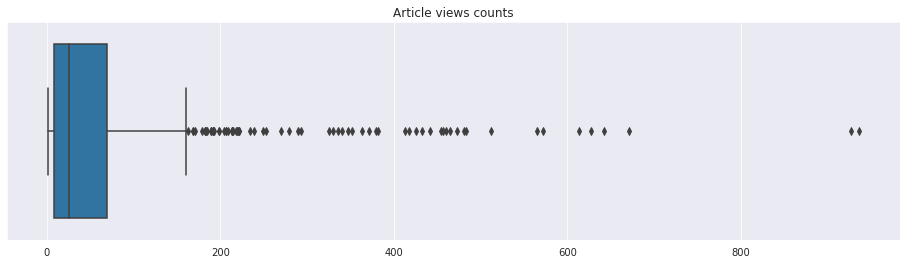

In [41]:
# Boxplot for the counts of how many times an article is viewed 
plt.figure(figsize=(16,4))

ax = sns.boxplot(x=article_views.views)

plt.title('Article views counts')
plt.xlabel('')
plt.show()

In [42]:
# The 10 most viewed articles
article_views.views.sort_values(ascending=False).head(10)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: views, dtype: int64

In [43]:
# The most popular article
most_viewed_article_id = str(df.groupby(
    'article_id').count()['user_id'].sort_values(ascending=False).index[0])
print(f'The most viewed article_id in the dataset is {most_viewed_article_id}.')

max_views = df.groupby(
    'article_id').count()['user_id'].sort_values(ascending=False).iloc[0]
print(f'The most viewed article in the dataset was viewed {max_views} times.')

The most viewed article_id in the dataset is 1429.0.
The most viewed article in the dataset was viewed 937 times.


In [44]:
# The second most popular article
second_most_viewed_article_id = str(
    df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index[1])
print(f'The second most viewed article_id in the dataset is {second_most_viewed_article_id}.')

second_max_views = df.groupby(
    'article_id').count()['user_id'].sort_values(ascending=False).iloc[1]
print(f'The second most viewed article in the dataset was viewed {second_max_views} times.')

The second most viewed article_id in the dataset is 1330.0.
The second most viewed article in the dataset was viewed 927 times.


In [45]:
# Create a dataframe to keep track of the users that accessed a certain article
users_per_article = pd.pivot_table(df,
                    values=['user_id'],
                    index='article_id',
                    aggfunc={'user_id': list})
users_per_article.reset_index(inplace=True)

# Check the outcome
users_per_article.head(2)

,article_id,user_id
0,0.0,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,2.0,"[676, 668, 668, 1145, 23, 23, 60, 60, 665, 98, 668, 794, 217, 60, 1401, 46, 1577, 789,..."


##  <font color='darkblue'>Dataframe with All Articles</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>The two datasets <tt>df</tt> and <tt>df_frame</tt> contain common articles, as well as articles that are in one dataset but not in the other.</li>
        <li>We form an outer join to combine all these articles, after which we will have to consolidate the article titles.</li>
    </ul>

</div>

In [46]:
# Extract article_id and title from df
df_titles = df[['article_id', 'title']].copy()
# Drop duplicates to obtain a clean list of articles
df_titles.drop_duplicates(inplace=True)

In [47]:
# Combine the titles with the view counts and the user lists
df_title_info = pd.merge(
    article_views, df_titles, on='article_id').merge(
    users_per_article, on='article_id').set_index('article_id')

# Check the outcome
df_title_info.head(2)

,views,title,user_id
article_id,,,
0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
2.0,58,"this week in data science (april 18, 2017)","[676, 668, 668, 1145, 23, 23, 60, 60, 665, 98, 668, 794, 217, 60, 1401, 46, 1577, 789,..."


In [48]:
# Perform an outer join of df_content and df_title_info dataframe
df_content_full = pd.merge(df_content, df_title_info, on='article_id', how='outer', indicator=True)
# Check the outcome
df_content_full.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id,views,title,user_id,_merge
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0.0,14.0,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]",both
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",Communicating data science: A guide to presenting your work,Live,1.0,NaN,NaN,NaN,left_only


In [49]:
# Count the missing values in the merged dataframe
df_content_full.isna().sum()

doc_body           291
doc_description    280
doc_full_name      277
doc_status         277
article_id           0
views              614
title              614
user_id            614
_merge               0
dtype: int64

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>Combine <tt>doc_full_name</tt> and <tt>title</tt> into a single column: <tt>doc_name</tt>.</li>
        <li>Drop: <tt>doc_status</tt>, <tt>doc_full_name</tt>, <tt>title</tt>, <tt>merge</tt>.</li>
        <li>Rename <tt>user_id</tt> to <tt>users_who_viewed</tt>.
        <li>Replace missing views by 0.</li>
        <li>Replace missing user list by [].</li>
    </ul>

</div>

In [50]:
# Create a function that picks the title 
def get_title(row):
    if row['_merge'] == 'left_only':
        return row['doc_full_name']
    else:
        return row['title']

In [51]:
# Create a new column that combines the available titles 
df_content_full['doc_name'] = df_content_full.apply(lambda x: get_title(x), axis=1)

# Check the outcome
df_content_full.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id,views,title,user_id,_merge,doc_name
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0.0,14.0,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]",both,detect malfunctioning iot sensors with streaming analytics
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",Communicating data science: A guide to presenting your work,Live,1.0,NaN,NaN,NaN,left_only,Communicating data science: A guide to presenting your work


In [52]:
# Create a new column where NaN values in user_id are replaced by empty lists
df_content_full['users_accessed'] = [ [] if x is np.NaN else x for x in df_content_full['user_id'] ]
df_content_full.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id,views,title,user_id,_merge,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0.0,14.0,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]",both,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",Communicating data science: A guide to presenting your work,Live,1.0,NaN,NaN,NaN,left_only,Communicating data science: A guide to presenting your work,[]


In [53]:
# Drop columns
df_content_full.drop(columns=['doc_full_name', 'doc_status', 'title', '_merge', 'user_id'], inplace=True)

# Check the outcome
df_content_full.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14.0,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,NaN,Communicating data science: A guide to presenting your work,[]


In [54]:
# Replace the missing views counts by 0
df_content_full['views'] = df_content_full['views'].fillna(0)

# Check the outcome
df_content_full.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14.0,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0.0,Communicating data science: A guide to presenting your work,[]


In [55]:
# The full information on an article in content dataframe
df_content_full.loc[528]

doc_body           Homepage About membership Sign in Get started Homepage Roman Kierzkowski Blocked Unblo...
doc_description    Jupyter Notebook (a.k.a iPython Notebook) is brilliant coding tool. It is ideal for do...
article_id                                                                                             528.0
views                                                                                                   32.0
doc_name                                                                   10 tips on using jupyter notebook
users_accessed     [94, 8, 8, 103, 429, 581, 2202, 1355, 2737, 45, 13, 40, 1035, 49, 256, 13, 205, 1063, ...
Name: 528, dtype: object

In [56]:
# The information on the same article from df dataframe
df[df.article_id==528]

,article_id,title,user_id
188,528.0,10 tips on using jupyter notebook,94
274,528.0,10 tips on using jupyter notebook,8
315,528.0,10 tips on using jupyter notebook,8
1429,528.0,10 tips on using jupyter notebook,103
1559,528.0,10 tips on using jupyter notebook,429
...,...,...,...
39933,528.0,10 tips on using jupyter notebook,4367
41633,528.0,10 tips on using jupyter notebook,4527
43633,528.0,10 tips on using jupyter notebook,4778
45395,528.0,10 tips on using jupyter notebook,4932


##  <font color='darkblue'>Overview Data and Adjust Dtypes</font>

#### User based dataframes

In [57]:
# Check the dtypes
df.dtypes

article_id    float64
title          object
user_id         int64
dtype: object

In [58]:
# Change dtypes
df['article_id'] = df['article_id'].astype(int)
# Check the outcome
df.dtypes

article_id     int64
title         object
user_id        int64
dtype: object

In [59]:
# Review the dataframe structure
df.head(2)

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314,healthcare python streaming application demo,2


In [60]:
# Check the dataframe size
df.shape

(45993, 3)

In [61]:
# Check dtypes
articles_per_user.dtypes

user_id                   int64
viewed_articles          object
articles_count            int64
unique_articles_count     int64
dtype: object

In [62]:
# Review the datfram structure
articles_per_user.head(2)

,user_id,viewed_articles,articles_count,unique_articles_count
0,1,"[1430.0, 1430.0, 732.0, 1429.0, 43.0, 109.0, 1232.0, 310.0, 1293.0, 1406.0, 1406.0, 32...",47,36
1,2,"[1314.0, 1305.0, 1024.0, 1176.0, 1422.0, 1427.0]",6,6


In [63]:
# Check the dataframe shape
articles_per_user.shape

(5149, 4)

#### Item based dataframes

In [64]:
df_content.dtypes

doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object

In [65]:
# Review the dataframe information
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
3,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
5,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",Communicating data science: A guide to presenting your work,Live,1


In [66]:
# Review the dataframe size
df_content.shape

(1051, 5)

In [67]:
# Check the available dtypes
df_content_full.dtypes

doc_body            object
doc_description     object
article_id         float64
views              float64
doc_name            object
users_accessed      object
dtype: object

In [68]:
# Change dtypes
df_content_full['views'] = df_content_full['views'].astype(int)
# Check the outcome
df_content_full.dtypes

doc_body            object
doc_description     object
article_id         float64
views                int64
doc_name            object
users_accessed      object
dtype: object

In [69]:
# Review the dataframe structure
df_content_full.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0,Communicating data science: A guide to presenting your work,[]


##  <font color='darkblue'>Save Data</font>

In [ ]:
# Save the cleaned data to files
df.to_csv('data/df.csv', index=True)
df_content.to_csv('data/df_content.csv', index=True)

# Save the user and articles information dataframes to files
articles_per_user.to_csv('data/articles_per_user.csv', index=True)
df_content_full.to_csv('data/users_per_article.csv', index=True)